# IBM Data Science course Capstone Project

In [298]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from collections import defaultdict

import xml.etree.ElementTree as et # library to parse XML files

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import requests # library to handle requests
import wikipedia as wp # library for loading data from Wikipedia
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.distance import geodesic # calculate distance between coordinates
import folium # map rendering library

from scipy.spatial.distance import cdist

from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
# import k-means from clustering stage
from sklearn.cluster import KMeans
from collections import Counter

from bs4 import BeautifulSoup # for webpage scraping

print('Libraries imported.')

Libraries imported.


***

# 1. Introduction

## 1.1. Background

Stockholm is the capital of Sweden and the most populous urban area in the Nordic countries. Stockholm has topped a list of Europe's fastest growing places, with the city's population expected to overcome one million in 2020. The Stockholm Region houses 2.5 million residents, just over one-quarter of Sweden's population, and generates over 30 percent of national economic output.

Stockholm is one of the most successful entrepreneurial environments in Europe, receiving $2.5 billion in venture capital investments since 2005.

Stockholm was recognized as the most innovative region in EU according to the 2017 Regional Innovation Scoreboard, presented by the European Commission. Dubbed the “unicorn” factory by the Financial Times in 2015, the Stockholm Region continues to attract more companies, investments and talents. As a result of a strong innovation infrastructure, based on academic and scientific research, Stockholm has a higher number of start-ups per capita than any other European city and one of the largest life science clusters in Europe.

## 1.2. Problem

A small group of talented minds is planning to move to Stockholm and start an innovative IT company. Some of the members of this group already have families with small kids. They are looking for a nice neighborhood to settle down. Considering sky high housing prices in central Stockholm they do not mind settling at some distance from the city.


## 1.3. Interest

Results of this study will be interested to anyone who is planning to move to Stockholm and settle down in a place that would fit their lifestyle.

***

# 2. Data Collection and Preparation

#### Find the coordinates of Stockholm with the help of GeoPy library

In [2]:
address = 'Stockholm, Sweden'
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

geolocator = Nominatim(user_agent = "to_explorer")
location = geolocator.geocode(address)
STO_latitude = location.latitude
STO_longitude = location.longitude
print('The geographical coordinates of Stockholm, Sweden are {}, {}.'.format(STO_latitude, STO_longitude))

The geographical coordinates of Stockholm, Sweden are 59.3251172, 18.0710935.


### 2.1. Let's now create a list of boroughs (districts) in Stockholm.

We will use BeautifulSoup library to scrape the corresponding Wikipedia page and extract required information

In [3]:
source1 = requests.get('https://en.wikipedia.org/wiki/Districts_of_Sweden').text
Stockholm_boroughs_data = BeautifulSoup(source1, 'lxml')
STO_boroughs_table = Stockholm_boroughs_data.find('div', {'class':'div-col columns column-width'})
STO_boroughs_table
Stockholm_boroughs_list = []
for link in STO_boroughs_table.find_all('a'):
    Stockholm_boroughs_list.append(link.text)
Stockholm_boroughs_df = pd.DataFrame(Stockholm_boroughs_list)
display(Stockholm_boroughs_df)
print('As of the administrative changes made in 2007 Stockholm now has {} districts:'.format(Stockholm_boroughs_df.shape[0]))

0
0                  Älvsjö
1                  Bromma
2    Enskede-Årsta-Vantör
3                  Farsta
4   Hägersten-Liljeholmen
5      Hässelby-Vällingby
6             Kungsholmen
7                Norrmalm
8               Östermalm
9           Rinkeby-Kista
10             Skärholmen
11              Skarpnäck
12              Södermalm
13          Spånga-Tensta

As of the administrative changes made in 2007 Stockholm now has 14 districts:


### Load GeoJson data for the administrative division of Stockholm Region and Stockholm municipality

In the file "Stockholm.geojson" I have combined the geo-information of both Stockholm Region and Stockholm municipality based on the original GeoJson files downloaded from "https://matsw.carto.com/tables/stockholms_l_n/public/map" and from "http://insideairbnb.com/get-the-data.html"

In [4]:
# Read the GeoJSON data and create a map of Stockholm using Folium
sto_geo = r'Stockholm.geojson' # geojson file

### 2.2. Web scrape the list of Stockholm's subway station from the Wikipedia page

In [5]:
source = requests.get('https://sv.wikipedia.org/wiki/Lista_%C3%B6ver_tunnelbanestationer_i_Stockholm').text
source.encode("utf-8-sig")
soup = BeautifulSoup(source, 'lxml')
STO_metro_table = soup.find('table', {'class':'sortable wikitable'})
STO_metro_table_rows = STO_metro_table.find_all('tr')
res = []
for row in STO_metro_table_rows:
    cols = row.find_all('td')
    cols = [col.text.strip() for col in cols]
    res.append([col.replace(u'\ufeff', '') for col in cols])
STO_metro_df = pd.DataFrame(res, columns=["Station", "Line", "Year", "Distance", "Municipality", "Type", "Position"])
STO_metro_df.head()

Station  Line  Year Distance       Municipality         Type  \
0          None  None  None     None               None         None   
1  Abrahamsberg  Grön  1952      8,1  Stockholms kommun    Ytstation   
2        Akalla   Blå  1977     14,5  Stockholms kommun  Bergstation   
3          Alby   Röd  1975     20,5    Botkyrka kommun  Bergstation   
4         Alvik  Grön  1952      6,5  Stockholms kommun    Ytstation   

                                            Position  
0                                               None  
1  59°20′12″N 17°57′11″E / 59.336680°N 17.952950°...  
2  59°24′53″N 17°54′46″E / 59.414814°N 17.912796°...  
3  59°14′22″N 17°50′43″E / 59.239498°N 17.845332°...  
4  59°20′01″N 17°58′49″E / 59.333633°N 17.980269°...

Now we need to extract the actual coordinates (latitude and longitude) from the 'Position' column

In [6]:
Position_df_tmp = STO_metro_df['Position'].str.rsplit('/', 1).str[1].str.split('(').str[0].str.split(';', expand = True)
STO_metro_df['Latitude'] = Position_df_tmp[0].astype(float)
STO_metro_df['Longitude'] = Position_df_tmp[1].astype(float)
STO_metro_df.head()

Station  Line  Year Distance       Municipality         Type  \
0          None  None  None     None               None         None   
1  Abrahamsberg  Grön  1952      8,1  Stockholms kommun    Ytstation   
2        Akalla   Blå  1977     14,5  Stockholms kommun  Bergstation   
3          Alby   Röd  1975     20,5    Botkyrka kommun  Bergstation   
4         Alvik  Grön  1952      6,5  Stockholms kommun    Ytstation   

                                            Position   Latitude  Longitude  
0                                               None        NaN        NaN  
1  59°20′12″N 17°57′11″E / 59.336680°N 17.952950°...  59.336680  17.952950  
2  59°24′53″N 17°54′46″E / 59.414814°N 17.912796°...  59.414814  17.912796  
3  59°14′22″N 17°50′43″E / 59.239498°N 17.845332°...  59.239498  17.845332  
4  59°20′01″N 17°58′49″E / 59.333633°N 17.980269°...  59.333633  17.980269

#### For the further analysis we will only need station name and its coordinates.

For this we will perform the following clean up:
  * Remove unopened station(s)
  * Remove duplicate station names. Some stations are listed several times in the original table since they belong to different lines.
  * Remove the old names of stations

In [7]:
# Remove unopened station(s). The opening year is missing in the "Year" column
STO_metro_df_1 = STO_metro_df[STO_metro_df['Year'].astype(str).str.isdigit()]

# Keep only the columns that we need for further analysis
#STO_metro_df_2 = STO_metro_df_1[['Station', 'Latitude', 'Longitude', 'Distance']].copy()
STO_metro_df_2 = STO_metro_df_1[['Station', 'Latitude', 'Longitude']].copy()

# Replace comma with '.' in the values of Distance and convert the values to floats
#STO_metro_df_2['Distance'] = STO_metro_df_2['Distance'].str.replace(',', '.').astype(float)

# Remove the duplicates among the stations
STO_metro_df_3 = STO_metro_df_2.drop_duplicates(["Station"]).reset_index(drop = True)

# Remove information about the previous station name
STO_metro_df_4 = STO_metro_df_3.copy()
STO_metro_df_4['Station'] = STO_metro_df_4['Station'].str.replace(r" \(.*\)","")

# Sort stations by the distance from the center
# STO_metro_df_4 = STO_metro_df_4.sort_values(by='Distance', ascending=True)

print('There are {} functioning subway stations in Stockholm now'.format(STO_metro_df_4.shape[0]))
display(STO_metro_df_4.head())

There are 100 functioning subway stations in Stockholm now


Station   Latitude  Longitude
0  Abrahamsberg  59.336680  17.952950
1        Akalla  59.414814  17.912796
2          Alby  59.239498  17.845332
3         Alvik  59.333633  17.980269
4      Aspudden  59.306449  18.001447

### Now let us load the list of commuter train (Pendeltåg) stations in Stockholm Region

In [9]:
# Load .csv data into a dataframe and set first column as Index
STO_commut_df = pd.read_csv('Pendeltåg.csv', header = None)
STO_commut_df.columns = ['Longitude', 'Latitude', 'Station Name', 'info']
STO_commut_df.head()

Longitude  Latitude                            Station Name  \
0    17.9726   59.3603          Sundbyberg station, Sundbyberg   
1    18.0101   59.3652  Solna Pendeltågsstation, Frösundaleden   
2    17.8988   59.3833     Spånga station, Spånga, Avestagatan   
3    18.0003   59.3807  Ulriksdals station, Solna, Kolonnvägen   
4    18.0294   59.3396             Karlberg station, Stockholm   

                            info  
0  Nedladdat från Koordinater.se  
1  Nedladdat från Koordinater.se  
2  Nedladdat från Koordinater.se  
3  Nedladdat från Koordinater.se  
4  Nedladdat från Koordinater.se

Let's limit the list of stations to only those within **20 km** distance from Stockholm center

In [11]:
rail_list = []
for name, lat, lon in zip(STO_commut_df['Station Name'], STO_commut_df['Latitude'], STO_commut_df['Longitude']):
    distance = round(geodesic((STO_latitude, STO_longitude), (lat, lon)).kilometers, 2)
    if distance <= 20:
        rail_list.append([name, lat, lon])
    else:
        pass
STO_commut_20km_df = pd.DataFrame(rail_list, columns = ['Station', 'Latitude', 'Longitude'])

print('There are {} commuter train (Pendeltåg) stations within 20 km distance from Stockholm center'.format(STO_commut_20km_df.shape[0]))
STO_commut_20km_df.head()

There are 30 commuter train (Pendeltåg) stations within 20 km distance from Stockholm center


Station  Latitude  Longitude
0          Sundbyberg station, Sundbyberg   59.3603    17.9726
1  Solna Pendeltågsstation, Frösundaleden   59.3652    18.0101
2     Spånga station, Spånga, Avestagatan   59.3833    17.8988
3  Ulriksdals station, Solna, Kolonnvägen   59.3807    18.0003
4             Karlberg station, Stockholm   59.3396    18.0294

#### For further analysis let's combine subway and commuter train stations dataframes.

In [12]:
STO_metro_rail_df = STO_metro_df_4.append(STO_commut_20km_df, ignore_index = True)
display(STO_metro_rail_df.head())
print(STO_metro_rail_df.shape)

Station   Latitude  Longitude
0  Abrahamsberg  59.336680  17.952950
1        Akalla  59.414814  17.912796
2          Alby  59.239498  17.845332
3         Alvik  59.333633  17.980269
4      Aspudden  59.306449  18.001447

(130, 3)


Let's also calculate the distance of all the stations from the Stockholm center.

In [91]:
rail_list_dist = []
for name, lat, lon in zip(STO_metro_rail_df['Station'], STO_metro_rail_df['Latitude'], STO_metro_rail_df['Longitude']):
    distance = round(geodesic((STO_latitude, STO_longitude), (lat, lon)).kilometers, 2)
    rail_list_dist.append([name, lat, lon, distance])
STO_commut_20km_dist_df = pd.DataFrame(rail_list_dist, columns = ['Station', 'Latitude', 'Longitude', 'Distance'])
display(STO_commut_20km_dist_df.head())
print(STO_commut_20km_dist_df.shape)

Station   Latitude  Longitude  Distance
0  Abrahamsberg  59.336680  17.952950      6.85
1        Akalla  59.414814  17.912796     13.45
2          Alby  59.239498  17.845332     16.02
3         Alvik  59.333633  17.980269      5.26
4      Aspudden  59.306449  18.001447      4.48

(130, 4)


### 2.3. Next we will utilize Foursquare API to explore areas in the vicinity of subway and railway stations

We will look for the venues in the radius of 500 m around subway and commuter train stations. The reason is that the average distance between subway stations is about 1 km. In this way we avoid overlapping and maintain reasonable walking distance.

#### Define Foursquare Credentials and Version

In [13]:
CLIENT_ID = 'XGXVFETTCMWO5AFU5E5LJMQEH1W00AEQKK2VZ3FO0AJDVYGC' # your Foursquare ID
CLIENT_SECRET = 'IDR2DXGE0MOJP1IKT1BTAHCZOVZMNCGBH2KJDVMXG4SLVBZA' # your Foursquare Secret
VERSION = '20191115' # Foursquare API version

Now we create a function that retrieves the 100 top venues around each station and stores them in a dataframe

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius = 500):
    LIMIT = 100
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Station', 
                'Latitude', 
                'Longitude', 
                'Venue', 
                'Venue Latitude', 
                'Venue Longitude', 
                'Venue Category']
    
    return(nearby_venues)

#### Retrieve all venues

In [15]:
STO_venues = getNearbyVenues(names = STO_metro_rail_df['Station'],
                                latitudes = STO_metro_rail_df['Latitude'],
                                longitudes = STO_metro_rail_df['Longitude']
                                  )

Abrahamsberg
Akalla
Alby
Alvik
Aspudden
Axelsberg
Bagarmossen
Bandhagen
Bergshamra
Björkhagen
Blackeberg
Blåsut
Bredäng
Brommaplan
Danderyds sjukhus
Duvbo
Enskede gård
Farsta
Farsta strand
Fittja
Fridhemsplan
Fruängen
Gamla stan
Globen
Gubbängen
Gullmarsplan
Gärdet
Hagsätra
Hallonbergen
Hallunda
Hammarbyhöjden
Hjulsta
Hornstull
Husby
Huvudsta
Hägerstensåsen
Hässelby gård
Hässelby strand
Högdalen
Hökarängen
Hötorget
Islandstorget
Johannelund
Karlaplan
Kista
Kristineberg
Kungsträdgården
Kärrtorp
Liljeholmen
Mariatorget
Masmo
Medborgarplatsen
Midsommarkransen
Mälarhöjden
Mörby centrum
Norsborg
Näckrosen
Odenplan
Rinkeby
Rissne
Ropsten
Råcksta
Rådhuset
Rådmansgatan
Rågsved
Sandsborg
Sankt Eriksplan
Skanstull
Skarpnäck
Skogskyrkogården
Skärholmen
Skärmarbrink
Slussen
Sockenplan
Solna centrum
Solna strand
Stadion
Stadshagen
Stora mossen
Stureby
Sundbybergs centrum
Svedmyra
Sätra
Tallkrogen
T-Centralen
Tekniska högskolan
Telefonplan
Tensta
Thorildsplan
Universitetet
Vårberg
Vårby gård
Välling

#### Let's see how our dataframe with the venue information look

But first we remove the venues under the category "Metro Station" since they will later interfer with the results of venue clustering

In [16]:
STO_venues.drop(STO_venues[STO_venues['Venue Category'] == 'Metro Station'].index, inplace = True)

Let's check how many venues were returned for each location

In [18]:
STO_venues.groupby(['Station'])[['Venue']].count().head()

Venue
Station            
Abrahamsberg      4
Akalla           13
Alby              5
Alvik            19
Aspudden         16

#### Let's find out how many unique categories can be curated from all the returned venues

In [19]:
print('There are {} uniques categories.'.format(len(STO_venues['Venue Category'].unique())))

There are 262 uniques categories.


Let's now download the list of Foursquare's categories (main and lower level)

In [116]:
# Define a dictionary to store subcategory (key) and all of its possible parents
SUBCATEGORIES = {}

def subcategorize(cat, prev):
    if cat.get('categories', False):
        
        lvl = len(prev) - 1
        for subcat in cat['categories']:
            
            child = subcat['name']
            subcategorize(subcat, prev + [child])
            if child not in SUBCATEGORIES:
                SUBCATEGORIES[child] = [(prev[0], 0)]
                
            for i in range(1, lvl + 1):
                SUBCATEGORIES[child].append((prev[i], i))

# Fetch categories from api
foursq_cat = requests.get('https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)).json()

# Subcategorize each category
for cat in foursq_cat['response']['categories']:
    name = cat['name']
    subcategorize(cat, [name])

# Populate a dataframe from SUBCATEGORIES dictionary
foursq_cat_df = pd.DataFrame(columns = ['Venue Category', 'Main Category', 'level'])
for k, v in SUBCATEGORIES.items():
    for sub, lvl in v:
        foursq_cat_df.loc[len(foursq_cat_df)] = (k, sub, lvl)

foursq_cat_df.to_csv('venue_subcategories.csv', index = False)

In [119]:
print(foursq_cat_df.shape)
display(foursq_cat_df)

(1515, 3)


Venue Category                Main Category  \
0                                 Amphitheater         Arts & Entertainment   
1                                     Aquarium         Arts & Entertainment   
2                                       Arcade         Arts & Entertainment   
3                                  Art Gallery         Arts & Entertainment   
4                                Bowling Alley         Arts & Entertainment   
5                                       Casino         Arts & Entertainment   
6                                       Circus         Arts & Entertainment   
7                                  Comedy Club         Arts & Entertainment   
8                                 Concert Hall         Arts & Entertainment   
9                           Country Dance Club         Arts & Entertainment   
10                                   Disc Golf         Arts & Entertainment   
11                                     Exhibit         Arts & Entertainment   
12                       General Entertainment         Arts & Entertainment   
13                               Go Kart Track         Arts & Entertainment   
14                               Historic Site         Arts & Entertainment   
15                                 Karaoke Box         Arts & Entertainment   
16                                   Laser Tag         Arts & Entertainment   
17                               Memorial Site         Arts & Entertainment   
18                                   Mini Golf         Arts & Entertainment   
19                            Drive-in Theater         Arts & Entertainment   
20                            Drive-in Theater                Movie Theater   
21                         Indie Movie Theater         Arts & Entertainment   
22                         Indie Movie Theater                Movie Theater   
23                                   Multiplex         Arts & Entertainment   
24                                   Multiplex                Movie Theater   
25                               Movie Theater         Arts & Entertainment   
26                                  Art Museum         Arts & Entertainment   
27                                  Art Museum                       Museum   
28                               Erotic Museum         Arts & Entertainment   
29                               Erotic Museum                       Museum   
30                              History Museum         Arts & Entertainment   
31                              History Museum                       Museum   
32                                 Planetarium         Arts & Entertainment   
33                                 Planetarium                       Museum   
34                              Science Museum         Arts & Entertainment   
35                              Science Museum                       Museum   
36                                      Museum         Arts & Entertainment   
37                                   Jazz Club         Arts & Entertainment   
38                                   Jazz Club                  Music Venue   
39                                   Piano Bar         Arts & Entertainment   
40                                   Piano Bar                  Music Venue   
41                                   Rock Club         Arts & Entertainment   
42                                   Rock Club                  Music Venue   
43                                 Music Venue         Arts & Entertainment   
44                             Pachinko Parlor         Arts & Entertainment   
45                                Dance Studio         Arts & Entertainment   
46                                Dance Studio        Performing Arts Venue   
47                               Indie Theater         Arts & Entertainment   
48                               Indie Theater        Performing Arts Venue   
49                                 Opera House         Arts & Entertainment   
50 

In [118]:
foursq_cat_nodup_df = foursq_cat_df.drop_duplicates(["Venue Category"], keep = "first")
print(foursq_cat_nodup_df.shape)
display(foursq_cat_nodup_df)

(927, 3)


Venue Category                Main Category  \
0                                 Amphitheater         Arts & Entertainment   
1                                     Aquarium         Arts & Entertainment   
2                                       Arcade         Arts & Entertainment   
3                                  Art Gallery         Arts & Entertainment   
4                                Bowling Alley         Arts & Entertainment   
5                                       Casino         Arts & Entertainment   
6                                       Circus         Arts & Entertainment   
7                                  Comedy Club         Arts & Entertainment   
8                                 Concert Hall         Arts & Entertainment   
9                           Country Dance Club         Arts & Entertainment   
10                                   Disc Golf         Arts & Entertainment   
11                                     Exhibit         Arts & Entertainment   
12                       General Entertainment         Arts & Entertainment   
13                               Go Kart Track         Arts & Entertainment   
14                               Historic Site         Arts & Entertainment   
15                                 Karaoke Box         Arts & Entertainment   
16                                   Laser Tag         Arts & Entertainment   
17                               Memorial Site         Arts & Entertainment   
18                                   Mini Golf         Arts & Entertainment   
19                            Drive-in Theater         Arts & Entertainment   
21                         Indie Movie Theater         Arts & Entertainment   
23                                   Multiplex         Arts & Entertainment   
25                               Movie Theater         Arts & Entertainment   
26                                  Art Museum         Arts & Entertainment   
28                               Erotic Museum         Arts & Entertainment   
30                              History Museum         Arts & Entertainment   
32                                 Planetarium         Arts & Entertainment   
34                              Science Museum         Arts & Entertainment   
36                                      Museum         Arts & Entertainment   
37                                   Jazz Club         Arts & Entertainment   
39                                   Piano Bar         Arts & Entertainment   
41                                   Rock Club         Arts & Entertainment   
43                                 Music Venue         Arts & Entertainment   
44                             Pachinko Parlor         Arts & Entertainment   
45                                Dance Studio         Arts & Entertainment   
47                               Indie Theater         Arts & Entertainment   
49                                 Opera House         Arts & Entertainment   
51                                     Theater         Arts & Entertainment   
53                       Performing Arts Venue         Arts & Entertainment   
54                                   Pool Hall         Arts & Entertainment   
55                           Outdoor Sculpture         Arts & Entertainment   
57                                  Street Art         Arts & Entertainment   
59                                  Public Art         Arts & Entertainment   
60                                  Racecourse         Arts & Entertainment   
61                                   Racetrack         Arts & Entertainment   
62                                 Roller Rink         Arts & Entertainment   
63                                  Salsa Club         Arts & Entertainment   
64                                Samba School         Arts & Entertainment   
65                            Baseball Stadium         Arts & Entertainment   
67                          Basketball Stadium         Arts & Entertainment   
69 

### 2.4. Now we load the list and location data of preschools in Stockholm municipality

In [78]:
!wget -q -O STO_preschool.xml http://api.stockholm.se/ServiceGuideService/ServiceUnitTypes/1c21b680-5136-4b43-98e3-cca969d20760/ServiceUnits?apikey=56010af30b114502bfbf8db404ef41a4

In [22]:
def parse_XML(xml_file, df_cols): 
    """
    Parse the input XML file and store the result in a pandas 
    DataFrame with the given columns. 
    """
    
    xtree = et.parse(xml_file)
    xroot = xtree.getroot()
    rows = []
    
    for node in xroot: 
        res = []
        res.append(node.attrib.get(df_cols[0]))
        res.append(node.find('GeographicalPosition').attrib.get(df_cols[1]))
        res.append(node.find('GeographicalPosition').attrib.get(df_cols[2]))
        rows.append({df_cols[i]: res[i] 
                     for i, _ in enumerate(df_cols)})
    
    out_df = pd.DataFrame(rows, columns=df_cols)
        
    return out_df

In [23]:
STO_preschool_df = parse_XML('STO_preschool.xml', ["name", "x", "y"])
STO_preschool_df.head()

name        x        y
0       Kavat, Filipstadsbacken 18  6570864  1631350
1       Brostugan, Lofotengatan 30  6589738  1620526
2            Förskolan Björnlandet  6583935  1629809
3                   Blomsterkungen  6586569  1613337
4  Regnbågen, Rågsveds skolgränd 5  6572835  1626518

However it appears that the coordinates of preschools are in the X/Y coordinate system. After short investigation I could find out that it is a Swedish coordinate system **RT90 2.5 gon V**.

So we need to convert the coordinates to latitude and longitude into **WGS84** coordinate system (GPS coordinates).

Fortunately there is a website Lantmäteriet (https://www.lantmateriet.se/en/) belonging to Swedish Ministry of Finance. With the help of their API coordinates can be easily converted.

First we will write a function that will send API calls for coordinate conversion and will store them in final form in a new dataframe

In [24]:
def CoordConvert(names, from_x, from_y):
    coords_list = []
    for name, x, y in zip(names, from_x, from_y):
        url = 'https://www.lantmateriet.se/api/epi/Transform?from=3&to=SWEREF%2099%20lat%20long%20(ellh)&id=16446&x={}&y={}&z='.format(x, y)
        results = json.loads(requests.get(url).json())

        if results['CalculatedX'] != None:
            pres_lat = [float(i) for i in results['CalculatedX'].split(': ')[1].split(' ')]
            pres_lng = [float(i) for i in results['CalculatedY'].split(': ')[1].split(' ')]
            pres_lat_conv = round(pres_lat[0] + pres_lat[1]/60 + pres_lat[2]/3600, 6)
            pres_lng_conv = round(pres_lng[0] + pres_lng[1]/60 + pres_lng[2]/3600, 6)
            coords_list.append([name, pres_lat_conv, pres_lng_conv])
        else:
            pass

    pres_coords = pd.DataFrame(coords_list)

    return(pres_coords)

#### Retrieve converted coordinates of preschools in Stockholm Region

In [26]:
Preschool_coords = CoordConvert(names = STO_preschool_df['name'],
                                from_x = STO_preschool_df['x'],
                                from_y = STO_preschool_df['y'])

In [27]:
Preschool_coords.columns = ['Name', 'Latitude', 'Longitude']
Preschool_coords.head()

Name   Latitude  Longitude
0       Kavat, Filipstadsbacken 18  59.238431  18.106699
1       Brostugan, Lofotengatan 30  59.410952  17.927724
2            Förskolan Björnlandet  59.356146  18.087560
3                   Blomsterkungen  59.384518  17.799540
4  Regnbågen, Rågsveds skolgränd 5  59.257580  18.023255

### 2.5. Now we load the house sales price information for Stockholm Municipality and Stockholm Region

In [28]:
# Load .csv data into a dataframe and set first column as Index
STO_houseprice_df = pd.read_csv('Stockholm - Tabell.csv')
print('House prices and price change in the last 12 months in Stockholm municipality')
display(STO_houseprice_df.head())

House prices and price change in the last 12 months in Stockholm municipality


Områden  Antal sålda  Kr/kvm  Pris tkr  Prisutveckling (%)
0                Bromma         1768   55533      3349                 3.0
1            Skärholmen         1231   44490      2899                -1.8
2             Skarpnäck         2206   56624      3204                 1.7
3  Enskede-Årsta-Vantör         2206   56624      3204                 1.7
4                Älvsjö          378   47227      2849                -0.1

In [29]:
STO_lan_houseprice_df = pd.read_csv('Stockholms län - Tabell.csv')
print('House prices and price change in the last 12 months in Stockholm Region')
display(STO_lan_houseprice_df.head())

House prices and price change in the last 12 months in Stockholm Region


Områden  Antal sålda  Kr/kvm  Pris tkr Prisutveckling (%)
0  Botkyrka          868   31320      1965               -1.4
1  Danderyd          342   56940      3706                 -1
2     Ekerö           99   39219      2933                 15
3   Haninge         1240   32031      2125                3.6
4  Huddinge         1209   37555      2412               -0.5

Combine the dataframes

In [30]:
STO_houseprice_tot_df = STO_houseprice_df.append(STO_lan_houseprice_df, ignore_index = True)
STO_houseprice_tot_df.columns = ['Name', 'Total sold', 'Kr/sqm', 'Price kKr', 'Price change']
STO_houseprice_tot_df.sort_values(by = ['Name'], ascending = True, inplace = True)
STO_houseprice_tot_df.drop(STO_houseprice_tot_df[STO_houseprice_tot_df['Name'] == 'Stockholm'].index, inplace = True)
STO_houseprice_tot_df["Price change"] = pd.to_numeric(STO_houseprice_tot_df["Price change"], errors = 'coerce')
STO_houseprice_tot_df["Price change"] = STO_houseprice_tot_df["Price change"].fillna(0)
STO_houseprice_tot_df.reset_index(inplace = True)
STO_houseprice_tot_df.drop(columns = ['index'], inplace = True)
print(STO_houseprice_tot_df.shape)
display(STO_houseprice_tot_df.head())

(39, 5)


Name  Total sold  Kr/sqm  Price kKr  Price change
0              Botkyrka         868   31320       1965          -1.4
1                Bromma        1768   55533       3349           3.0
2              Danderyd         342   56940       3706          -1.0
3                 Ekerö          99   39219       2933          15.0
4  Enskede-Årsta-Vantör        2206   56624       3204           1.7

### 2.6. Finally we obtain the demographic information for Stockholm Municipality and Stockholm Region

In [31]:
source2 = requests.get('https://ugeo.urbistat.com/AdminStat/en/se/classifiche/popolazione/comuni/stockholms-lan/1/3').text
STO_dem_size_src = BeautifulSoup(source2, 'lxml')
STO_dem_size_table = STO_dem_size_src.find('table', {'class':'table_result_light tablesorter'})
# Parse the table to extract relevant information
STO_dem_size_rows = STO_dem_size_table.find_all('tr')
STO_dem_size_data = []
for row in STO_dem_size_rows:
    td = []
    for t in row.find_all('td'):
        td.append(t.text.strip())
    STO_dem_size_data.append(td)

# Create new DataFrame
STO_dem_size_df = pd.DataFrame(STO_dem_size_data)#, columns = STO_dem_size_column_names)
STO_dem_size_df.drop(columns = [0, 3, 4, 5], axis = 1, inplace = True)
STO_dem_size_df.drop(STO_dem_size_df.index[0], inplace = True)
STO_dem_size_df.drop(STO_dem_size_df.index[39], inplace = True)
STO_dem_size_df.columns = ['Name', 'Population size']
#STO_dem_size_df["Name"] = STO_dem_size_df["Name"].str.replace("_Stockholm", "")
STO_dem_size_df.sort_values(by = ['Name'], ascending = True, inplace = True)
print(STO_dem_size_df.shape)
display(STO_dem_size_df.head())

(39, 2)


Name Population size
6                         Botkyrka          93,106
10                Bromma_Stockholm          80,249
32                        Danderyd          33,187
35                           Ekerö          28,308
4   Enskede-Årsta-Vantör_Stockholm         101,116

In [32]:
source3 = requests.get('https://ugeo.urbistat.com/AdminStat/en/se/classifiche/densita-demografica/comuni/stockholms-lan/1/3').text
STO_dem_dens_src = BeautifulSoup(source3, 'lxml')
STO_dem_dens_table = STO_dem_dens_src.find('table', {'class':'table_result_light tablesorter'})
# Parse the table to extract relevant information
STO_dem_dens_rows = STO_dem_dens_table.find_all('tr')
STO_dem_dens_data = []
for row in STO_dem_dens_rows:
    td = []
    for t in row.find_all('td'):
        td.append(t.text.strip())
    STO_dem_dens_data.append(td)

# Create new DataFrame
STO_dem_dens_df = pd.DataFrame(STO_dem_dens_data)
STO_dem_dens_df.drop(columns = [0, 3], axis = 1, inplace = True)
STO_dem_dens_df.drop(STO_dem_dens_df.index[0], inplace = True)
STO_dem_dens_df.drop(STO_dem_dens_df.index[26], inplace = True)
STO_dem_dens_df.columns = ['Name', 'Population density']
#STO_dem_dens_df["Name"] = STO_dem_dens_df["Name"].str.replace("_Stockholm", "")
STO_dem_dens_df.sort_values(by = ['Name'], ascending = True, inplace = True)
print(STO_dem_dens_df.shape)
display(STO_dem_dens_df.head())

(39, 2)


Name Population density
26                        Botkyrka                439
15                Bromma_Stockholm              2,899
19                        Danderyd              1,020
38                           Ekerö                 73
6   Enskede-Årsta-Vantör_Stockholm              4,714

Merge dataframes

In [33]:
STO_population_df = STO_dem_size_df.merge(STO_dem_dens_df, how = 'left', on = 'Name')
STO_population_df['Population size'] = STO_population_df['Population size'].str.replace(",", "").astype(int)
STO_population_df['Population density'] = STO_population_df['Population density'].str.replace(",", "").astype(int)
STO_population_df["Name"] = STO_population_df["Name"].str.replace("_Stockholm", "")
print(STO_population_df.shape)
display(STO_population_df)

(39, 3)


Name  Population size  Population density
0                Botkyrka            93106                 439
1                  Bromma            80249                2899
2                Danderyd            33187                1020
3                   Ekerö            28308                  73
4    Enskede-Årsta-Vantör           101116                4714
5                  Farsta            59370                3457
6                 Haninge            89989                 203
7                Huddinge           111722                 792
8   Hägersten-Liljeholmen            90433                6019
9      Hässelby-Vällingby            76097                3036
10               Järfälla            78480                1230
11            Kungsholmen            71372               10255
12                Lidingö            47818                 935
13                  Nacka           103656                 802
14               Norrmalm            71983               13254
15              Norrtälje            61769                  30
16                Nykvarn            10923                  61
17              Nynäshamn            28290                  79
18          Rinkeby-Kista            50532                3622
19                  Salem            16786                 233
20                Sigtuna            48130                 137
21              Skarpnäck            46545                2625
22             Skärholmen            37444                3622
23             Sollentuna            72528                1243
24                  Solna            80950                3715
25          Spånga-Tensta            39206                3808
26             Sundbyberg            50564                5556
27              Södermalm           130367               12528
28             Södertälje            97381                 159
29                 Tyresö            48004                 475
30                   Täby            71397                1005
31         Upplands Väsby            45543                 540
32           Upplands-Bro            28756                  88
33             Vallentuna            33432                  90
34                Vaxholm            12023                 116
35                 Värmdö            44397                  98
36                 Älvsjö            30658                3224
37              Östermalm            76782                3139
38              Österåker            44831                 140

***

# 3.    Methodology

## 3.1. Exploratory data analysis

In order to keep commuting times reasonable we will limit the study to the area within 20 km distance from Stockholm center

### 3.1.1. Display demographic information for Stockholm Region with the help of choroplet map

Format a map

In [92]:
sto_map = folium.Map(location = [STO_latitude, STO_longitude], zoom_start = 10)

Create fixed scale for the colormap

In [54]:
# Create a numpy array of length 6 that has linear spacing from the minimum population density in Stockholm Region to the maximum
threshold_scale = np.linspace(STO_population_df['Population density'].min(),
                              STO_population_df['Population density'].max(),
                              6, dtype = int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum population density

Display the choropleth map with the demographic information

In [93]:
folium.Choropleth(
    geo_data = sto_geo,
    data = STO_population_df,
    columns = ['Name', 'Population density'],
    key_on = 'feature.properties.name',
    threshold_scale = threshold_scale,
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = 'Population density in Stockholm, person/sq.km.',
    reset = True
).add_to(sto_map)

# Plot the circle of 15 km radius around Stockholm center
folium.Circle([STO_latitude, STO_longitude],
                    radius = 20000
                   ).add_to(sto_map)

sto_map

### 3.1.2. Plot the map of housing prices over the past 12 months

In [64]:
sto_price_map = folium.Map(location = [STO_latitude, STO_longitude], zoom_start = 10)

# Create a numpy array of length 6 that has linear spacing from the minimum population density in Stockholm Region to the maximum
threshold_scale_price = np.linspace(STO_houseprice_tot_df['Kr/sqm'].min(),
                              STO_houseprice_tot_df['Kr/sqm'].max(),
                              6, dtype = int)
# change the numpy array to a list
threshold_scale_price = threshold_scale_price.tolist()
# make sure that the last value of the list is greater than the maximum population density
threshold_scale_price[-1] = threshold_scale_price[-1] + 1

folium.Choropleth(
    geo_data = sto_geo,
    data = STO_houseprice_tot_df,
    columns = ['Name', 'Kr/sqm'],
    key_on = 'feature.properties.name',
    threshold_scale = threshold_scale_price,
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = 'Housing prices in Stockholm, Kr/sqm.',
    reset = True
).add_to(sto_price_map)

# Plot the circle of 15 km radius around Stockholm center
folium.Circle([STO_latitude, STO_longitude],
                    radius = 20000
                   ).add_to(sto_price_map)

sto_price_map

#### As we can see, prices in the central Stockholm are almost 2 times higher per square meter compared to more distant districts, and almost 4 times higher compared to other municipalities in Stockholm Region

Let's check how housing prices correlate with the population density

Text(0, 0.5, 'Price, Kr/sqm')

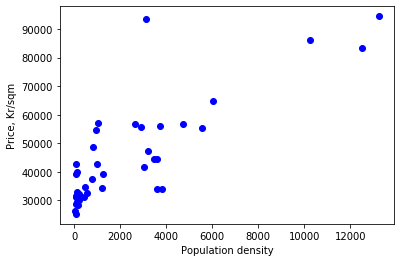

In [83]:
plt.scatter(STO_population_df['Population density'], STO_houseprice_tot_df['Kr/sqm'], color = 'blue')
plt.xlabel("Population density")
plt.ylabel("Price, Kr/sqm")

As we can see there seem to be a correlation between population density and the housing prices in Stockholm Region, which is actualy not that surprising.

But let's look at this dependency a bit deeper and use the method of polynomial regression, utilizing the **sklearn** package to model our data.

Although we will not try to do any predictions at this point as we simply do not have enough data, and there might be other factors affecting housing prices.

In [82]:
pop_x = np.asanyarray(STO_population_df[['Population density']])
pop_y = np.asanyarray(STO_houseprice_tot_df[['Kr/sqm']])

# We will use second degree polynomial
poly = PolynomialFeatures(degree = 2)
pop_x_poly = poly.fit_transform(pop_x)

Now we build and fit the model

In [77]:
clf = linear_model.LinearRegression()
pop_y_ = clf.fit(pop_x_poly, pop_y)
# The coefficients
print ('Coefficients: ', clf.coef_)
print ('Intercept: ',clf.intercept_)

Coefficients:  [[ 0.00000000e+00  5.46604939e+00 -8.59050530e-05]]
Intercept:  [33625.94246327]


And finally we plot the data together with the model we just built

Text(0, 0.5, 'Price, Kr/sqm')

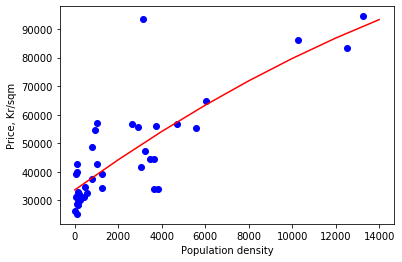

In [81]:
plt.scatter(STO_population_df['Population density'], STO_houseprice_tot_df['Kr/sqm'], color = 'blue')
pop_XX = np.arange(0.0, 14500.0, 2000)
pop_yy = clf.intercept_[0] + clf.coef_[0][1]*pop_XX + clf.coef_[0][2]*np.power(pop_XX, 2)
plt.plot(pop_XX, pop_yy, '-r' )
plt.xlabel("Population density")
plt.ylabel("Price, Kr/sqm")

### 3.1.3. Display subway and commuter train stations on the map

In [94]:
# Add location of subway stations
for lat, lng, station in zip(STO_metro_df_4['Latitude'], STO_metro_df_4['Longitude'], STO_metro_df_4['Station']):
    label = '{}'.format(station)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 3,
        popup=label,
        color = 'darkblue',
        fill = True,
        fill_color = 'beige',
        fill_opacity = 0.7,
        parse_html = False).add_to(sto_map)

# Add location of commuter train stations
for lat, lng, station in zip(STO_commut_20km_df['Latitude'], STO_commut_20km_df['Longitude'], STO_commut_20km_df['Station']):
    label = '{}'.format(station)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 3,
        popup = label,
        color = 'darkgreen',
        fill = True,
        fill_color = 'beige',
        fill_opacity = 0.7,
        parse_html = False).add_to(sto_map)

sto_map

As we can see from the map most subway and some commuter train stations are located within areas with higher population density. Only few are located in less populated areas.

Let's also see if there are areas with lower housing prices that are easily accessed by subway or commuter trains

In [96]:
# Add location of subway stations
for lat, lng, station in zip(STO_metro_df_4['Latitude'], STO_metro_df_4['Longitude'], STO_metro_df_4['Station']):
    label = '{}'.format(station)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 3,
        popup=label,
        color = 'darkblue',
        fill = True,
        fill_color = 'beige',
        fill_opacity = 0.7,
        parse_html = False).add_to(sto_price_map)

# Add location of commuter train stations
for lat, lng, station in zip(STO_commut_20km_df['Latitude'], STO_commut_20km_df['Longitude'], STO_commut_20km_df['Station']):
    label = '{}'.format(station)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 3,
        popup = label,
        color = 'darkgreen',
        fill = True,
        fill_color = 'beige',
        fill_opacity = 0.7,
        parse_html = False).add_to(sto_price_map)

sto_price_map

### 3.1.4. Display the location of preschools in Stockholm

In [128]:
sto_presc_map = folium.Map(location = [STO_latitude, STO_longitude], zoom_start = 10)

folium.Choropleth(
    geo_data = sto_geo,
    data = STO_population_df,
    columns = ['Name', 'Population density'],
    key_on = 'feature.properties.name',
    threshold_scale = threshold_scale,
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = 'Population density in Stockholm, person/sq.km.',
    reset = True
).add_to(sto_presc_map)

# Add location of commuter train stations
for lat, lng, station in zip(Preschool_coords['Latitude'], Preschool_coords['Longitude'], Preschool_coords['Name']):
    label = '{}'.format(station)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 1,
        popup = label,
        color = 'darkred',
        fill = True,
        fill_color = 'beige',
        fill_opacity = 0.7,
        parse_html = False).add_to(sto_presc_map)

# Plot the circle of 20 km radius around Stockholm center
folium.Circle([STO_latitude, STO_longitude],
                    radius = 20000
                   ).add_to(sto_presc_map)

sto_presc_map

### 3.1.5. Explore the Foursquare data

First, let's how many venues we have identified

In [103]:
print('There were total {} venues identified within 500 meters from subway and commuter train stations'.format(STO_venues.shape[0]))

There were total 2965 venues identified within 500 meters from subway and commuter train stations


Since we also have a separate dataset with the preschool locations, let's check if the venue dataset from Foursquare already contains preschools.

In [134]:
presc_df = STO_venues.loc[STO_venues['Venue Category'] == 'Preschool']
print('There are {} preschools in the venue dataset obtained from Foursquare'.format(presc_df.shape[0]))

There are 0 preschools in the venue dataset obtained from Foursquare


This means that before we proceed further and if we want to do more thorough analysis of the locations we should try to combine the venue dataset with the preschool location dataset

In [160]:
interim_list = []
ColumnList = ['Station', 'Latitude', 'Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
cat_name = 'Preschool'
for station, lat, lon in zip(STO_metro_rail_df['Station'], STO_metro_rail_df['Latitude'], STO_metro_rail_df['Longitude']):
    for name, p_lat, p_lon in zip(Preschool_coords['Name'], Preschool_coords['Latitude'], Preschool_coords['Longitude']):
        distance = round(geodesic((lat, lon), (p_lat, p_lon)).meters)

        if distance <= 500:
            interim_list.append([station, lat, lon, name, p_lat, p_lon, cat_name])
        else:
            pass

STO_presc_venues = pd.DataFrame.from_records(interim_list, columns = ColumnList)

In [162]:
print('There are {} preschools located within 500 meters from subway and commuter train stations'.format(STO_presc_venues.shape[0]))
display(STO_presc_venues.head())

There are 633 preschools located within 500 meters from subway and commuter train stations


Station  Latitude  Longitude  \
0  Abrahamsberg  59.33668   17.95295   
1  Abrahamsberg  59.33668   17.95295   
2  Abrahamsberg  59.33668   17.95295   
3  Abrahamsberg  59.33668   17.95295   
4  Abrahamsberg  59.33668   17.95295   

                                              Venue  Venue Latitude  \
0        Föräldrakooperativet Storken, Sunnanstigen       59.337541   
1                         Förskolan Sunnanstigen 11       59.337672   
2                           Förskolan Bävervägen 43       59.334022   
3                     Förskolan Gustav III:s väg 36       59.333838   
4  Montessoriförskolan Liten och Stor, Stopvägen 37       59.335316   

   Venue Longitude Venue Category  
0        17.954869      Preschool  
1        17.955089      Preschool  
2        17.953698      Preschool  
3        17.946305      Preschool  
4        17.946011      Preschool

In [185]:
#print(Preschool_coords.shape[0])
#print(STO_presc_venues.shape[0])
nearby_presc = round((100 / Preschool_coords.shape[0])*STO_presc_venues.shape[0])
print('As we can see \033[1m{}%\033[0m of all preschools in Stockholm municipality are conveniently located within the reasonable walking distance (500 meters) from subway and commuter train stations'.format(nearby_presc))

As we can see 69% of all preschools in Stockholm municipality are conveniently located within the reasonable walking distance (500 meters) from subway and commuter train stations


Now let's combine new preschool dataframe with the venue dataset from Foursquare

In [173]:
STO_venues_complete = pd.concat([STO_venues, STO_presc_venues], sort = False, ignore_index = True)
STO_venues_complete.sort_values(by = 'Station', inplace = True)
STO_venues_complete.reset_index(drop = True, inplace = True)
STO_venues_complete.head()

Station  Latitude  Longitude  \
0  Abrahamsberg  59.33668   17.95295   
1  Abrahamsberg  59.33668   17.95295   
2  Abrahamsberg  59.33668   17.95295   
3  Abrahamsberg  59.33668   17.95295   
4  Abrahamsberg  59.33668   17.95295   

                                              Venue  Venue Latitude  \
0                    Friskis & Svettis Abrahamsberg       59.337785   
1                                 Pizzeria La Bella       59.333929   
2                                 Pizzeria Kaktusen       59.335903   
3                                    Texas Longhorn       59.336699   
4  Montessoriförskolan Liten och Stor, Stopvägen 37       59.335316   

   Venue Longitude        Venue Category  
0        17.948774  Gym / Fitness Center  
1        17.947791           Pizza Place  
2        17.952260           Pizza Place  
3        17.956992            Steakhouse  
4        17.946011             Preschool

**Finally we are ready to proceed!**

To get more insights into Forsquare data let's combine the venue data with the Foursquare main category data

In [174]:
STO_venues_cat = STO_venues_complete.merge(foursq_cat_nodup_df, how = 'left', on = 'Venue Category')
print(STO_venues_cat.shape)
display(STO_venues_cat.head())

(3598, 9)


Station  Latitude  Longitude  \
0  Abrahamsberg  59.33668   17.95295   
1  Abrahamsberg  59.33668   17.95295   
2  Abrahamsberg  59.33668   17.95295   
3  Abrahamsberg  59.33668   17.95295   
4  Abrahamsberg  59.33668   17.95295   

                                              Venue  Venue Latitude  \
0                    Friskis & Svettis Abrahamsberg       59.337785   
1                                 Pizzeria La Bella       59.333929   
2                                 Pizzeria Kaktusen       59.335903   
3                                    Texas Longhorn       59.336699   
4  Montessoriförskolan Liten och Stor, Stopvägen 37       59.335316   

   Venue Longitude        Venue Category                Main Category level  
0        17.948774  Gym / Fitness Center        Outdoors & Recreation     0  
1        17.947791           Pizza Place                         Food     0  
2        17.952260           Pizza Place                         Food     0  
3        17.956992            Steakhouse                         Food     0  
4        17.946011             Preschool  Professional & Other Places     0

Let's calculate the occurences and the percentage of different venue categories in the dataset

In [175]:
STO_venues_cat_grouped = STO_venues_cat.groupby('Main Category')['Venue Category'].count().reset_index()
STO_venues_cat_grouped['Percent'] = STO_venues_cat_grouped['Venue Category']/STO_venues_cat_grouped['Venue Category'].sum()*100
STO_venues_cat_grouped = STO_venues_cat_grouped.sort_values('Percent', ascending = False)
STO_venues_cat_grouped.round({'Percent': 1})

Main Category  Venue Category  Percent
2                         Food            1473     41.0
5  Professional & Other Places             669     18.6
6               Shop & Service             575     16.0
4        Outdoors & Recreation             309      8.6
7           Travel & Transport             234      6.5
3               Nightlife Spot             199      5.5
0         Arts & Entertainment             133      3.7
1         College & University               3      0.1

Interesting to note that category "Professional & Other Places" is the socond largest after "Food" category. Out of **669** venues in this category **633** are preschools.

Now let's calculate the number of venues per subway and commuter trains station. We also add the information on the distance from the city center

In [316]:
venues_per_station = STO_venues_cat.groupby('Station')['Venue'].count().reset_index()
venues_per_station_dist = venues_per_station.merge(STO_commut_20km_dist_df, how = 'left', on = 'Station')
venues_per_station_dist.drop(columns = ['Longitude','Latitude'], inplace = True)
print(venues_per_station_dist.shape)
display(venues_per_station_dist.sort_values('Venue', ascending = False))

(130, 3)


Station  Venue  Distance
63                                   Medborgarplatsen    123      1.21
70                                           Odenplan    120      2.33
77                                       Rådmansgatan    107      1.86
129                                    Östermalmstorg    106      1.11
76                                           Rådhuset    104      1.75
97                           Stockholm Centralstation    103      0.91
49                                           Hötorget    103      1.24
108                                       T-Centralen    102      0.94
61                                        Mariatorget    101      1.01
25                                       Fridhemsplan    101      2.51
27                                         Gamla stan     99      0.29
98   Stockholm södra station, Stockholm, Fatbursgatan     99      1.27
58                                    Kungsträdgården     98      0.64
99     Stockholmscentralstation, Stockholm, Vasagatan     98      0.94
88                                            Slussen     79      0.63
124                                       Zinkensdamm     67      1.45
79                            Saltsjöbanan, Stockholm     66      0.54
54                                          Karlaplan     61      1.90
56                                              Kista     61     11.34
81                                    Sankt Eriksplan     59      2.53
39                                          Hornstull     53      2.35
105                               Sundbybergs centrum     46      6.90
60                                        Liljeholmen     45      3.17
82                                          Skanstull     45      1.95
104                    Sundbyberg station, Sundbyberg     42      6.84
103                        Sundbyberg Järnvägsstation     42      6.96
110                                Tekniska högskolan     37      2.31
111                                       Telefonplan     35      5.16
96                                         Stadshagen     34      3.33
113                                      Thorildsplan     34      3.26
55                        Karlberg station, Stockholm     33      2.87
18                                             Farsta     32      9.17
90                      Sollentuna station, Tingvägen     30     13.51
95                                            Stadion     29      2.08
92                                      Solna centrum     29      5.56
86                                         Skärholmen     27     10.77
64                                   Midsommarkransen     26      4.25
26                                           Fruängen     25      7.46
28                                             Globen     25      3.46
31                                             Gärdet     25      2.92
59                                           Kärrtorp     24      5.16
128                                          Örnsberg     24      5.15
57                                       Kristineberg     23      3.96
30                                       Gullmarsplan     23      2.95
4                                            Aspudden     22      4.48
1                                              Akalla     21     13.45
16                                              Duvbo     21      7.71
119                                         Vällingby     21     12.10
3                                               Alvik     20      5.26
19                                      Farsta strand     19     10.19
93                                       Solna strand     19      6.41
20       Farsta strand station, Farsta, Battforsgatan     18     10.03
12                                             Blåsut     18      4.05
120                                        Västertorp     18      7.04
83                                          Skarpnäck     18      7.40
43                                     Hägerstensåsen     18      6.19

Let's check how the number of venues is distributed depending on the distance from the city center by creating a scatter plot:

Text(0, 0.5, 'Number of venues')

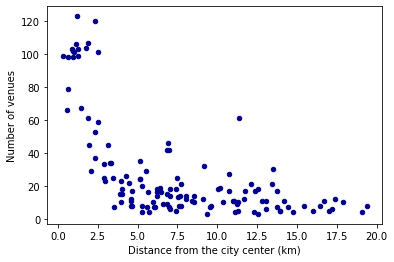

In [189]:
venues_vs_distance = venues_per_station_dist.plot.scatter(x = 'Distance', y = 'Venue', c = 'DarkBlue')

# Set the x-axis label
venues_vs_distance.set_xlabel("Distance from the city center (km)")
# Set the y-axis label
venues_vs_distance.set_ylabel("Number of venues")

## 3.2. Data preparation

To begin preparing the data for further clustering, let's remove all of the stations with 5 or less venues since it's most likely not enough to get reliable results.

In [318]:
STO_venues_2 = STO_venues_cat.groupby('Station').filter(lambda x : len(x) > 5)
STO_venues_2.shape

(3538, 9)

We will move stations with 5 or less venues to a separate dataframe

In [226]:
venues_below5_per_station = venues_per_station.drop(venues_per_station[venues_per_station['Venue'] > 5].index)
venues_below5_per_station.drop('Venue', 1).head()

Station
2                                               Alby
21                        Fisksätra Pendeltågstation
22                                            Fittja
23                      Flemingsberg Järnvägsstation
24  Flemingsbergs station, Huddinge, Björnkullavägen

In [233]:
venues_below5_per_station.shape

(14, 2)

Check, how many unique categories we are left with in the dataframe, which we will use for clustering:

In [319]:
print('There are {} uniques categories.'.format(len(STO_venues_2['Venue Category'].unique())))

There are 260 uniques categories.


To prepare the dataset for clustering and deal with categorical values (e.g., venue categories) we perform one hot encoding

In [320]:
STO_onehot = pd.get_dummies(STO_venues_2[['Venue Category']], prefix = "", prefix_sep = "")

# add neighbourhood column back to dataframe
STO_onehot['Station'] = STO_venues_2['Station'] 

# move neighbourhood column to the first column
fixed_columns = [STO_onehot.columns[-1]] + list(STO_onehot.columns[:-1])
STO_onehot = STO_onehot[fixed_columns]

STO_onehot.head()

0               0       0          0             0   
4                   0               0       0          0             0   

   Clothing Store  Cocktail Bar  Coffee Shop  College Gym  Comic Shop  \
0               0             0            0            0           0   
1               0             0            0            0           0   
2               0             0            0            0           0   
3               0             0            0            0           0   
4               0             0            0            0           0   

   Community Center  Concert Hall  Convenience Store  Convention Center  \
0                 0             0                  0                  0   
1                 0             0                  0                  0   
2                 0             0                  0                  0   
3                 0             0                  0                  0   
4                 0             0                  0                  0   

   Cosmetics Shop  Coworking Space  Creperie  Cupcake Shop  Czech Restaurant  \
0               0                0         0             0                 0   
1               0                0         0             0                 0   
2               0                0         0             0                 0   
3               0                0         0             0                 0   
4               0                0         0             0                 0   

   Dance Studio  Deli / Bodega  Department Store  Design Studio  Dessert Shop  \
0             0              0                 0              0             0   
1             0              0                 0              0             0   
2             0              0                 0              0             0   
3             0              0                 0              0             0   
4             0              0                 0              0             0   

   Diner  Discount Store  Dive Bar  Doctor's Office  Dumpling Restaurant  \
0      0               0         0                0                    0   
1      0               0         0                0                    0   
2      0               0         0                0                    0   
3      0               0         0                0                    0   
4      0               0         0                0                    0   

   Eastern European Restaurant  Electronics Store  Ethiopian Restaurant  \
0                            0                  0                     0   
1                            0                  0                     0   
2                            0                  0                     0   
3                            0                  0                     0   
4                            0                  0                     0   

   Event Space  Falafel Restaurant  Farm  Farmers Market  \
0            0                   0     0               0   
1            0                   0     0               0   
2            0                   0     0               0   
3            0                   0     0               0   
4            0                   0     0               0   

   Fast Food Restaurant  Fish & Chips Shop  Flea Market  Flower Shop  Food  \
0                     0                  0            0            0     0   
1                     0                  0            0            0     0   
2                     0                  0            0            0     0   
3                     0                  0            0            0     0   
4                     0                  0            0            0     0   

   Food & Drink Shop  Food Court  Food Truck  Fountain  Frame Store  \
0                  0           0           0         0            0   
1                  0           0           0         0            0   
2                  0           0           0         0        

In [321]:
STO_onehot.shape

(3538, 261)

Now let's normamilze the data by grouping rows by station and taking the mean of the frequency of occurrence of each category:

In [322]:
STO_grouped = STO_onehot.groupby('Station').mean().reset_index()
STO_grouped.head()

0.0     0.0        0.0           0.0   

   Clothing Store  Cocktail Bar  Coffee Shop  College Gym  Comic Shop  \
0             0.0           0.0          0.0          0.0         0.0   
1             0.0           0.0          0.0          0.0         0.0   
2             0.0           0.0          0.0          0.0         0.0   
3             0.0           0.0          0.0          0.0         0.0   
4             0.0           0.0          0.0          0.0         0.0   

   Community Center  Concert Hall  Convenience Store  Convention Center  \
0               0.0           0.0           0.000000                0.0   
1               0.0           0.0           0.047619                0.0   
2               0.0           0.0           0.050000                0.0   
3               0.0           0.0           0.045455                0.0   
4               0.0           0.0           0.000000                0.0   

   Cosmetics Shop  Coworking Space  Creperie  Cupcake Shop  Czech Restaurant  \
0             0.0              0.0       0.0           0.0               0.0   
1             0.0              0.0       0.0           0.0               0.0   
2             0.0              0.0       0.0           0.0               0.0   
3             0.0              0.0       0.0           0.0               0.0   
4             0.0              0.0       0.0           0.0               0.0   

   Dance Studio  Deli / Bodega  Department Store  Design Studio  Dessert Shop  \
0           0.0            0.0               0.0            0.0           0.0   
1           0.0            0.0               0.0            0.0           0.0   
2           0.0            0.0               0.0            0.0           0.0   
3           0.0            0.0               0.0            0.0           0.0   
4           0.0            0.0               0.0            0.0           0.0   

   Diner  Discount Store  Dive Bar  Doctor's Office  Dumpling Restaurant  \
0    0.0             0.0       0.0              0.0                  0.0   
1    0.0             0.0       0.0              0.0                  0.0   
2    0.0             0.0       0.0              0.0                  0.0   
3    0.0             0.0       0.0              0.0                  0.0   
4    0.0             0.0       0.0              0.0                  0.0   

   Eastern European Restaurant  Electronics Store  Ethiopian Restaurant  \
0                          0.0                0.0                   0.0   
1                          0.0                0.0                   0.0   
2                          0.0                0.0                   0.0   
3                          0.0                0.0                   0.0   
4                          0.0                0.0                   0.0   

   Event Space  Falafel Restaurant      Farm  Farmers Market  \
0          0.0                 0.0  0.000000             0.0   
1          0.0                 0.0  0.095238             0.0   
2          0.0                 0.0  0.000000             0.0   
3          0.0                 0.0  0.000000             0.0   
4          0.0                 0.0  0.000000             0.0   

   Fast Food Restaurant  Fish & Chips Shop  Flea Market  Flower Shop  Food  \
0                   0.0                0.0          0.0          0.0   0.0   
1                   0.0                0.0          0.0          0.0   0.0   
2                   0.0                0.0          0.0          0.0   0.0   
3                   0.0                0.0          0.0          0.0   0.0   
4                   0.0                0.0          0.0          0.0   0.0   

   Food & Drink Shop  Food Court  Food Truck  Fountain  Frame Store  \
0                0.0         0.0         0.0       0.0          0.0   
1                0.0         0.0         0.0       0.0          0.0   
2                0.0         0.0         0.0       0.0          0.0   
3                0.0         0.0         0.0       0.0 

In [323]:
print('So at the end we have {} rows, one for each station, and {} columns, one for each venue category'.format(STO_grouped.shape[0], STO_grouped.shape[1]))

So at the end we have 116 rows, one for each station, and 261 columns, one for each venue category


***

## 3.3. Clustering

### 3.3.1. Find the optimal number of clusters

To determine the optimal number of clusters (K) we will use ** Elbow method **

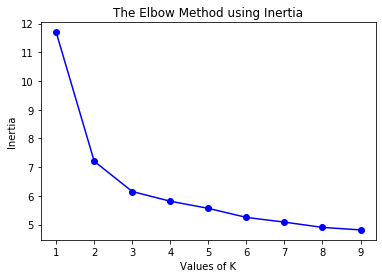

In [340]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10)
X = STO_grouped.drop('Station', 1)
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters = k).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis = 1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis = 1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

plt.plot(K, inertias, 'bo-') 
plt.xlabel('Values of K')
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

According to the results of “Elbow method” looks like ** k = 3 ** might be the best number of clusters

### 3.3.2. K-means clustering

Let's run k-means clustering with the number of clusters ** k = 3 **

In [342]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(X)

# Let's see how many stations belong to each cluster
print(Counter(kmeans.labels_))

Counter({0: 48, 2: 43, 1: 25})


Let's add location information back to clustered stations

In [343]:
#create new dataframe for the clustered stations (as the opposite to the stations in the dataframe above)
STO_clustered_stations = STO_grouped.copy()
STO_clustered_stations.insert(0, 'Cluster Labels', kmeans.labels_)

# Add coordinates to the dataset above
STO_clustered_stations = STO_clustered_stations.join(STO_commut_20km_dist_df.set_index('Station'), on = 'Station')
print(STO_clustered_stations.shape)
display(STO_clustered_stations.head())

(116, 265)


Cluster Labels       Station  ATM  Accessories Store  Advertising Agency  \
0               1  Abrahamsberg  0.0                0.0                 0.0   
1               2        Akalla  0.0                0.0                 0.0   
2               0         Alvik  0.0                0.0                 0.0   
3               2      Aspudden  0.0                0.0                 0.0   
4               1     Axelsberg  0.0                0.0                 0.0   

   African Restaurant  American Restaurant  Amphitheater  Antique Shop  \
0                 0.0                  0.0           0.0           0.0   
1                 0.0                  0.0           0.0           0.0   
2                 0.0                  0.0           0.0           0.0   
3                 0.0                  0.0           0.0           0.0   
4                 0.0                  0.0           0.0           0.0   

   Arcade  Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  \
0     0.0          0.0         0.0                  0.0          0.000000   
1     0.0          0.0         0.0                  0.0          0.047619   
2     0.0          0.0         0.0                  0.0          0.000000   
3     0.0          0.0         0.0                  0.0          0.000000   
4     0.0          0.0         0.0                  0.0          0.000000   

   Athletics & Sports  Auto Dealership  Auto Workshop  Automotive Shop  \
0                 0.0              0.0            0.0              0.0   
1                 0.0              0.0            0.0              0.0   
2                 0.0              0.0            0.0              0.0   
3                 0.0              0.0            0.0              0.0   
4                 0.0              0.0            0.0              0.0   

   BBQ Joint  Badminton Court  Bagel Shop    Bakery  Bar  Basketball Court  \
0        0.0              0.0         0.0  0.000000  0.0               0.0   
1        0.0              0.0         0.0  0.000000  0.0               0.0   
2        0.0              0.0         0.0  0.000000  0.0               0.0   
3        0.0              0.0         0.0  0.045455  0.0               0.0   
4        0.0              0.0         0.0  0.000000  0.0               0.0   

   Beach  Beer Bar  Beer Garden  Beer Store  Bike Rental / Bike Share  \
0    0.0       0.0          0.0         0.0                       0.0   
1    0.0       0.0          0.0         0.0                       0.0   
2    0.0       0.0          0.0         0.0                       0.0   
3    0.0       0.0          0.0         0.0                       0.0   
4    0.0       0.0          0.0         0.0                       0.0   

   Bike Shop    Bistro  Boat or Ferry  Bookstore  Boutique  Bowling Alley  \
0        0.0  0.000000            0.0   0.000000       0.0            0.0   
1        0.0  0.000000            0.0   0.000000       0.0            0.0   
2        0.0  0.000000            0.0   0.000000       0.0            0.0   
3        0.0  0.045455            0.0   0.045455       0.0            0.0   
4        0.0  0.000000            0.0   0.000000       0.0            0.0   

   Boxing Gym  Brazilian Restaurant  Breakfast Spot  Brewery  Bridge  \
0         0.0                   0.0             0.0      0.0     0.0   
1         0.0                   0.0             0.0      0.0     0.0   
2         0.0                   0.0             0.0      0.0     0.0   
3         0.0                   0.0             0.0      0.0     0.0   
4         0.0                   0.0             0.0      0.0     0.0   

   Burger Joint  Bus Line  Bus Station  Bus Stop  Business Service  Butcher  \
0           0.0       0.0          0.0  0.000000               0.0      0.0   
1           0.0       0.0          0.0  0.047619               0.0      0.0   
2           0.0       0.0          0.0  0.000000               0.0      0.0   
3           0.0       0.0          0.0  0.000000       

Before we proceed with cluster visualization, let's get back to the stations with 5 and less venues and create one more cluster.

In [344]:
venues_below5_per_station_1 = venues_below5_per_station.copy()
venues_below5_per_station_1['Cluster Labels'] = kclusters

# Add coordinates to the dataset above and clean the unnecessary information (Distance)  
venues_below5_per_station_1 = venues_below5_per_station_1.join(STO_commut_20km_dist_df.set_index('Station'), on = 'Station')
venues_below5_per_station_1.drop("Distance", axis = 1, inplace = True)
print(venues_below5_per_station_1.shape)
display(venues_below5_per_station_1.head())

(14, 5)


Station  Venue  Cluster Labels  \
2                                               Alby      5               3   
21                        Fisksätra Pendeltågstation      4               3   
22                                            Fittja      4               3   
23                      Flemingsberg Järnvägsstation      5               3   
24  Flemingsbergs station, Huddinge, Björnkullavägen      5               3   

     Latitude  Longitude  
2   59.239498  17.845332  
21  59.293900  18.256800  
22  59.247462  17.860964  
23  59.217600  17.946300  
24  59.217900  17.945700

Finally let's combine this two dataframes to have all 5 clusters together

In [345]:
STO_clust_merged = pd.concat([STO_clustered_stations, venues_below5_per_station_1], axis = 0, ignore_index = True, sort = False)
STO_clust_merged = STO_clust_merged[['Station','Cluster Labels','Latitude','Longitude']]
STO_clust_merged.head()

Station  Cluster Labels   Latitude  Longitude
0  Abrahamsberg               1  59.336680  17.952950
1        Akalla               2  59.414814  17.912796
2         Alvik               0  59.333633  17.980269
3      Aspudden               2  59.306449  18.001447
4     Axelsberg               1  59.304364  17.974920

Now we can visualize station clusters on the map.

As a background we will use administrative division and choropleth map representing density of population

In [350]:
cluster_map = folium.Map(location = [STO_latitude, STO_longitude], zoom_start = 10)

# Add choropleth map with demographic information
folium.Choropleth(
    geo_data = sto_geo,
    data = STO_population_df,
    columns = ['Name', 'Population density'],
    key_on = 'feature.properties.name',
    threshold_scale = threshold_scale,
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = 'Population density in Stockholm, person/sq.km.',
    reset = True
).add_to(cluster_map)

# Set the color scheme for the clusters and add markers to the map
colors = ['red', 'green', 'blue', 'black']
fillers = ['red', 'green', 'blue', 'beige']

# Add clusters of stations to the map
for lat, lon, poi, cluster in zip(STO_clust_merged['Latitude'],
                                STO_clust_merged['Longitude'],
                                STO_clust_merged['Station'],
                                STO_clust_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = colors[cluster],
        fill = True,
        fill_color = fillers[cluster],
        fill_opacity = 0.7).add_to(cluster_map)

# Plot the circle of 20 km radius around Stockholm center
folium.Circle([STO_latitude, STO_longitude],
                    radius = 20000
                   ).add_to(cluster_map)

cluster_map

### 3.3.3. Examine clusters

In [355]:
# Create new dataframe with only the cluster labels and metro stations:
cluster_info = STO_clust_merged[['Cluster Labels','Station']]

# Merge this information with the dataframe that contains all of the venues and columns of the interest:
describe_clusters = STO_venues_cat
describe_clusters = describe_clusters.merge(cluster_info, how = "left", on = "Station")
describe_clusters_1 = describe_clusters[['Station','Venue Category','Main Category','Cluster Labels']]

# Remove the stations with 5 and less venues
describe_clusters_1.drop(describe_clusters_1[describe_clusters_1['Cluster Labels'] == 3].index, inplace = True) 
print(describe_clusters_1.shape)
display(describe_clusters_1.head())

(3538, 4)


Station        Venue Category                Main Category  \
0  Abrahamsberg  Gym / Fitness Center        Outdoors & Recreation   
1  Abrahamsberg           Pizza Place                         Food   
2  Abrahamsberg           Pizza Place                         Food   
3  Abrahamsberg            Steakhouse                         Food   
4  Abrahamsberg             Preschool  Professional & Other Places   

   Cluster Labels  
0               1  
1               1  
2               1  
3               1  
4               1

Let's now perform some descriptive analysis of the clusters

$\color{red}{\text{Cluster 0 (Red)}}$

In [365]:
main_cat_clusters = describe_clusters_1.groupby(['Cluster Labels','Main Category'])['Venue Category'].count().reset_index()
main_cat_clusters.sort_values('Venue Category', ascending = False, inplace = True)
main_cat_cluster_0 = main_cat_clusters[main_cat_clusters['Cluster Labels'] == 0].copy()
main_cat_cluster_0['Percent'] = round(main_cat_cluster_0['Venue Category']/main_cat_cluster_0['Venue Category'].sum()*100,1)
main_cat_cluster_0 = main_cat_cluster_0.sort_values('Venue Category', ascending = False)
main_cat_cluster_0

Cluster Labels                Main Category  Venue Category  Percent
2               0                         Food             846     47.8
6               0               Shop & Service             301     17.0
7               0           Travel & Transport             157      8.9
4               0        Outdoors & Recreation             145      8.2
3               0               Nightlife Spot             130      7.3
5               0  Professional & Other Places             100      5.7
0               0         Arts & Entertainment              87      4.9
1               0         College & University               3      0.2

$\color{green}{\text{Cluster 1 (Green)}}$

In [367]:
main_cat_cluster_1 = main_cat_clusters[main_cat_clusters['Cluster Labels'] == 1].copy()
main_cat_cluster_1['Percent'] = round(main_cat_cluster_1['Venue Category']/main_cat_cluster_1['Venue Category'].sum()*100,1)
main_cat_cluster_1 = main_cat_cluster_1.sort_values('Venue Category', ascending = False)
main_cat_cluster_1

Cluster Labels                Main Category  Venue Category  Percent
12               1  Professional & Other Places             182     58.5
9                1                         Food              50     16.1
13               1               Shop & Service              41     13.2
11               1        Outdoors & Recreation              25      8.0
14               1           Travel & Transport              11      3.5
10               1               Nightlife Spot               1      0.3
8                1         Arts & Entertainment               1      0.3

$\color{blue}{\text{Cluster 2 (Blue)}}$

In [368]:
main_cat_cluster_2 = main_cat_clusters[main_cat_clusters['Cluster Labels'] == 2].copy()
main_cat_cluster_2['Percent'] = round(main_cat_cluster_2['Venue Category']/main_cat_cluster_2['Venue Category'].sum()*100,1)
main_cat_cluster_2 = main_cat_cluster_2.sort_values('Venue Category', ascending = False)
main_cat_cluster_2

Cluster Labels                Main Category  Venue Category  Percent
16               2                         Food             564     38.8
19               2  Professional & Other Places             383     26.3
20               2               Shop & Service             213     14.6
18               2        Outdoors & Recreation             132      9.1
17               2               Nightlife Spot              67      4.6
21               2           Travel & Transport              52      3.6
15               2         Arts & Entertainment              44      3.0

Now let's check what are the ** 10 ** most common venues on the lower level of classification in each of the clusters

$\color{red}{\text{Cluster 0 (Red)}}$

In [371]:
detailed_cat_clusters = describe_clusters_1.groupby(['Cluster Labels','Venue Category'])['Main Category'].count().reset_index()
detailed_cat_clusters = detailed_cat_clusters.sort_values(by = ['Main Category'], ascending = False)
detailed_cat_clusters[detailed_cat_clusters['Cluster Labels'] == 0].head(10)

Cluster Labels           Venue Category  Main Category
33                0                     Café            104
164               0  Scandinavian Restaurant             97
99                0                    Hotel             78
155               0                Preschool             76
147               0              Pizza Place             52
107               0       Italian Restaurant             45
88                0     Gym / Fitness Center             45
14                0                   Bakery             43
8                 0         Asian Restaurant             42
44                0              Coffee Shop             40

$\color{green}{\text{Cluster 1 (Green)}}$

In [372]:
detailed_cat_clusters[detailed_cat_clusters['Cluster Labels'] == 1].head(10)

Cluster Labels        Venue Category  Main Category
234               1             Preschool            181
231               1           Pizza Place             17
219               1         Grocery Store             13
214               1     Convenience Store             10
232               1                 Plaza              7
221               1  Gym / Fitness Center              6
243               1           Supermarket              6
210               1              Bus Stop              6
207               1                Bakery              5
245               1       Thai Restaurant              4

$\color{blue}{\text{Cluster 2 (Blue)}}$

In [373]:
detailed_cat_clusters[detailed_cat_clusters['Cluster Labels'] == 2].head(10)

Cluster Labels           Venue Category  Main Category
396               2                Preschool            373
283               2                     Café             59
263               2                   Bakery             54
390               2              Pizza Place             45
426               2          Thai Restaurant             34
335               2            Grocery Store             31
337               2     Gym / Fitness Center             31
420               2         Sushi Restaurant             31
403               2  Scandinavian Restaurant             28
419               2              Supermarket             26

***

## 4. Results

As a result of our analysis we have identified 4 clusters of locations centered around subway and commuter train stations.
  * $\color{red}{\text{Cluster 0 (Red)}}$: has the highest number of venues, large portion of which is located close to the city center. The most common categories of venues beginning with the largest category are Food, Shop & Service, Travel & Transport, Outdoors & Recreation, Nightlife Spot and Arts & Entertainment. Within category Food, the most common venues are cafés, Scandinavian restaurants, pizza places, Italian restaurants and bakeries. This cluster would be of interest to those who either not yet planning to fill up their life with family/kids, or whos kids already grew up.

  * $\color{green}{\text{Cluster 1 (Green)}}$: has the lowest number of venues among the clusters. This cluster is located outside the central part of Stockholm. The most common categories of venues are Professional & Other Places, Food, Shop & Service, Outdoors & Recreation and Travel & Transport. Over half of the Professional & Other Places consist of preschools. Within category Food, the most common venues are pizza places. This cluster might be interesting to young families with small kids. Considerable number of preschools will satisfy the requirements for child day care. And small number of other venues mean rather quiet atmosphere around.

  * $\color{blue}{\text{Cluster 2 (Blue)}}$: is located mainly outside of the city center. The most common categories of venues are Food, Professional & Other Places, Shop & Service, Outdoors & Recreation and Nightlife Spot. Although Food category is the larges for this cluster,main venues are preschools. Within category Food, the most common venues are cafés, bakeries, pizza places, Thai and Sushi restaurants. This cluster will be of interest to young families who either already got small kids, or have such plans for near future. Preschools are at almost every corner ready to take care of small ones. And the rest of infrastructure seem to be well thought of with many restaurants, shops and gyms.
  
  * And the remaining category includes areas with very small number of venues. Might be a good place for those who either want to have some quietness in their lives.

## 5. Discussion

The purpose of this study was to analyse neighbourhoods within and around Stockholm municipality and identify promising locations that would fit requirements and lifestyles of some of the members of newborn IT startup company. One of the main requirements was easy access to subway and commuter trains, which represent rather reliable and fast means of transportation.

Analysis was done using some openly available data, both from swedish government sources and Foursquare. Since Foursquare is mainly focused on food related venues, the venue data from Foursquare was supplemented by a complete list of preschools within Stockholm municipality. Added information about population density and housing prices may help better identify the place where a person would want to settle down after deciding to move to Stockholm.

Further development of this study might be to include information on the venues not covered by Foursquare:
  * Preschools outside Stockholm municipality (e.g., in Solna, which looks like an attractive are to live)
  * Schools (for families with school-age kids)
  * Healthcare infrastructure
  * Housing prices that include not only apartment prices, but also houses (e.g., villas)

Analysis can be also extended to areas beyond 500 m distance from subway and commuter train stations.

## 6. Conclusions

In this study I have tried to provide some recommendations to those who decided to move to Stockholm in order to find a good place to settle down, which would fit their lifestyle. Subway and commuter train stations were chosen as a sort of "ancor" points and were clustered into three main clusters based on the type of venues that surround them. As it is the case in many modern cities, the central areas of Stockholm are more suitable for people with active lifestyle, while more distant areas would better satisfy needs of families with younger kids.
